# 3D spleen segmentation with MONAI

Segmentation is a common task where the goal is to identify a particular object in an image (in this case, we will try to identify the spleen from abdominal CT). We will train a model to take as input a CT and return a label image where voxels inside the spleen are labeled 1 and others are labeled 0. The training data consists of CT images along with hand-segmented label images.

This example shows how to use the following features:
1. Create transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity to within an expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. Create a UNet model with a Dice loss function for 3D segmentation.
1. Use a sliding window method for inference.
1. Use deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size


You should run this notebook with GPU hardware acceleration. On Google Colab, you can go to Edit -> Notebook Settings and select GPU to enable this.

## Install and import necessary packages

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 KB 4.5 MB/s eta 0:00:00


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

## Print package versions for reproducibility

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 1.2.dev2306
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4fd4fb01b9f5e329f1efb55b52bdcd0d6f95497f
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmphitulbn0


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

This download could take several minutes.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:42, 15.7MB/s]                            

2023-02-06 13:53:55,736 - INFO - Downloaded: /tmp/tmphitulbn0/Task09_Spleen.tar


2023-02-06 13:53:58,634 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-02-06 13:53:58,635 - INFO - Writing into directory: /tmp/tmphitulbn0.


## Set MSD Spleen dataset path

We split the data (CT images in imagesTr, label images in labelsTr) into separate training and validation datasets.

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data is shaped with the channel dimension first.
1. `Orientationd` unifies the data orientation (in this case we are using RAS).
1. `Spacingd` adjusts the spacing to `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts the intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crops patch samples from the full image based on the positive/negative label ratio.  
The image centers of negative samples must be in a valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. for data augmentation.

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Verify that the data looks correct by visualizing images using the DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


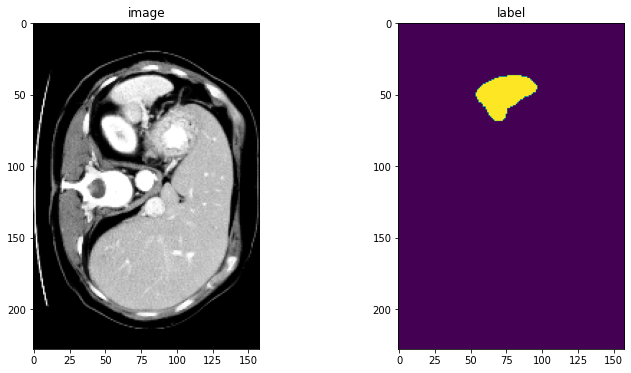

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate the training and validation process. It's faster than the regular Dataset because it caches the results of non-random transforms applied to the data.  

To achieve best performance, set `cache_rate=1.0` to cache all the data. If there is not enough memory, set a lower value.   

Users can also set `cache_num` instead of `cache_rate` to cache a specific number of images. The minimum value of the 2 settings will be used. You can also set `num_workers` to enable multiple threads during caching.  

Building the cache can take a couple of minutes.

If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 32/32 [01:09<00:00,  2.18s/it]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


## Create Model, Loss, Optimizer

For the model we are using U-Net, a popular architecture for both 2D and 3D image segmentation. It is a convolutional network named for its shape (see below) and is a popular choice for medical applications because it generally requires less training data than other segmentation approaches. See [this paper](https://arxiv.org/abs/1505.04597) for more information.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="512">

For loss we are using [Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), which is a measure of overlap between the estimated and target segmentations. Dice does not work well for all types of objects, such as thin objects were small changes in the object lead to large changes in overlap, but it should work well for the spleen.

In [25]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

Normally, this would be run for a large number of epochs until the loss starts to converge, which could take quite a while depending on the hardware it is running on. We will use a smaller number (50) here to demonstrate the training process and see some intermediate results. Later we will load a fully trained model to see how the results can improve after further training.

If you'd rather run the full training yourself, change `max_epochs` below to 600.

In [ ]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50
1/16, train_loss: 0.6642
2/16, train_loss: 0.6765
3/16, train_loss: 0.6728
4/16, train_loss: 0.6668
5/16, train_loss: 0.6559
6/16, train_loss: 0.6678
7/16, train_loss: 0.6444
8/16, train_loss: 0.6664
9/16, train_loss: 0.6518
10/16, train_loss: 0.6375
11/16, train_loss: 0.6569
12/16, train_loss: 0.6300
13/16, train_loss: 0.6521
14/16, train_loss: 0.6571
15/16, train_loss: 0.6549
16/16, train_loss: 0.6258
epoch 1 average loss: 0.6551
----------
epoch 2/50
1/16, train_loss: 0.6078
2/16, train_loss: 0.6501
3/16, train_loss: 0.6468
4/16, train_loss: 0.6380
5/16, train_loss: 0.6559
6/16, train_loss: 0.6135
7/16, train_loss: 0.6224
8/16, train_loss: 0.6330
9/16, train_loss: 0.6217
10/16, train_loss: 0.6015
11/16, train_loss: 0.6424
12/16, train_loss: 0.6243
13/16, train_loss: 0.6521
14/16, train_loss: 0.6216
15/16, train_loss: 0.6332
16/16, train_loss: 0.6160
epoch 2 average loss: 0.6300
saved new best metric model
current epoch: 2 current mean dice: 0.0342
best mean dic

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1721 at epoch: 38


## Plot the loss and metric

Here we can see how the loss function is changing over time and how the model is performing on the vaidation set. 

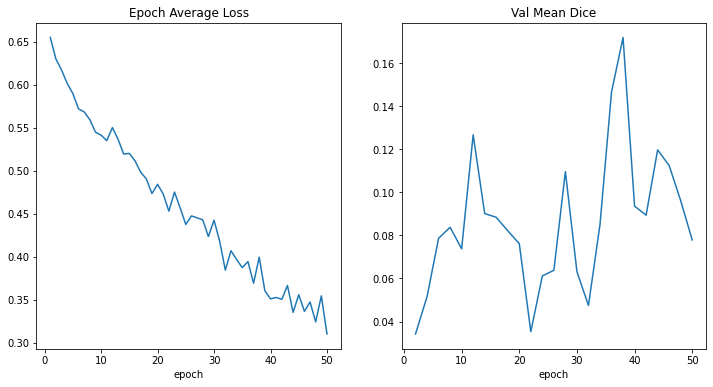

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Compare output of the best model with ground truth

If you ran with 50 epochs above, these results will show that the model is starting to learn where the spleen is but many cases will still have strange errors. This is an indicator that the model is on track but needs more training.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


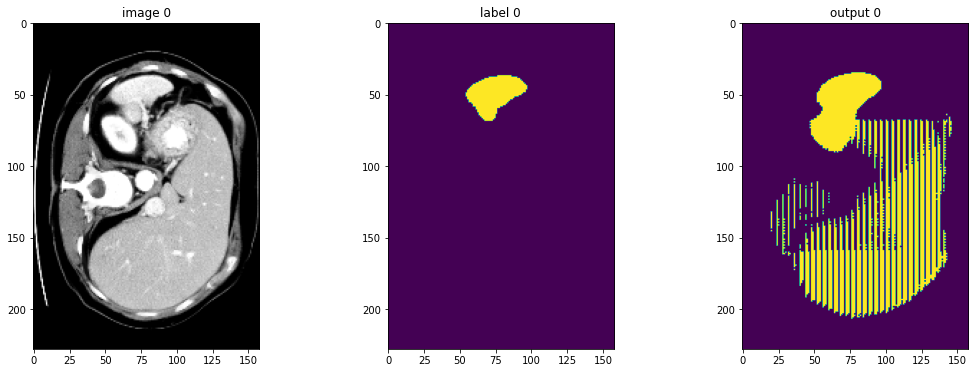

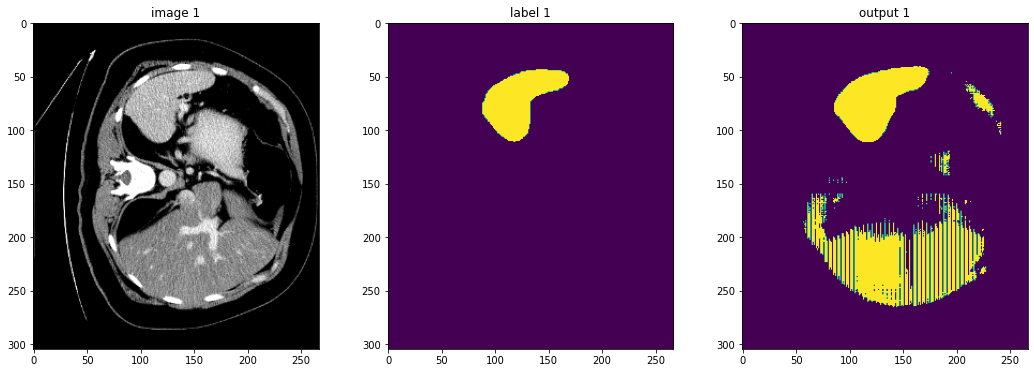

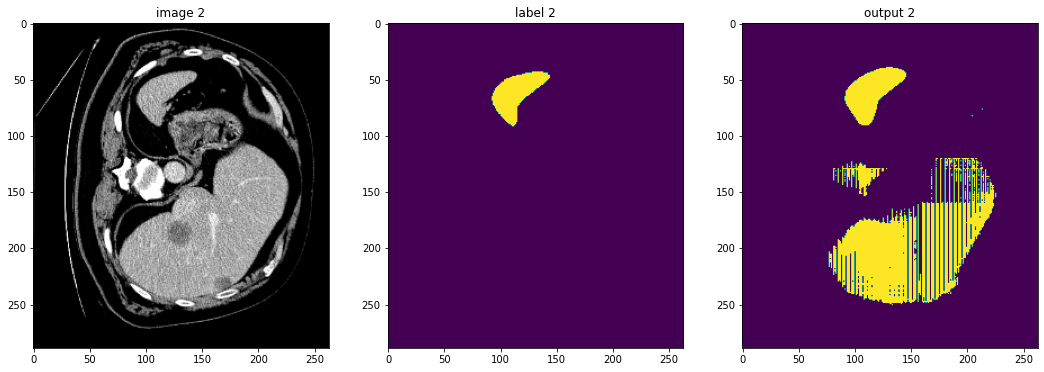

In [ ]:
def visualize_model(model):
  with torch.no_grad():
    for i, val_data in enumerate(val_loader):
      roi_size = (160, 160, 160)
      sw_batch_size = 4
      val_outputs = sliding_window_inference(
          val_data["image"].to(device), roi_size, sw_batch_size, model
      )
      # plot the slice [:, :, 80]
      plt.figure("check", (18, 6))
      plt.subplot(1, 3, 1)
      plt.title(f"image {i}")
      plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
      plt.subplot(1, 3, 2)
      plt.title(f"label {i}")
      plt.imshow(val_data["label"][0, 0, :, :, 80])
      plt.subplot(1, 3, 3)
      plt.title(f"output {i}")
      plt.imshow(torch.argmax(
          val_outputs, dim=1).detach().cpu()[0, :, :, 80])
      plt.show()
      if i == 2:
          break
  
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
visualize_model(model)

## Download a fully trained model and see full training results

This model was trained for 600 epochs on the same dataset. By that point the loss will have leveled off and validation error will be small.

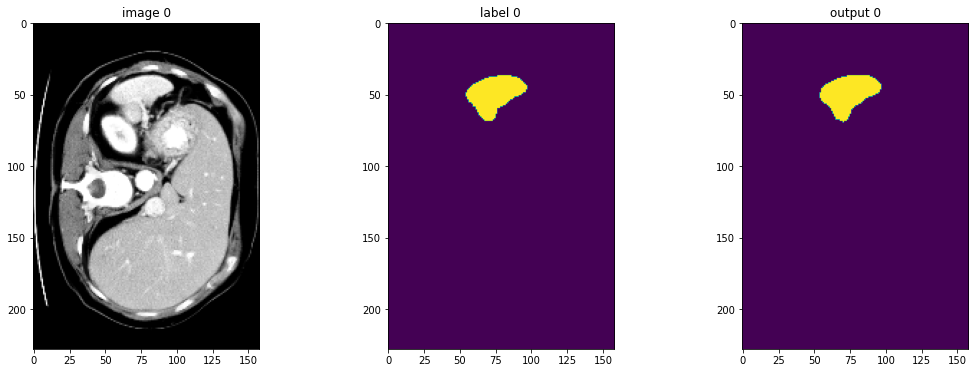

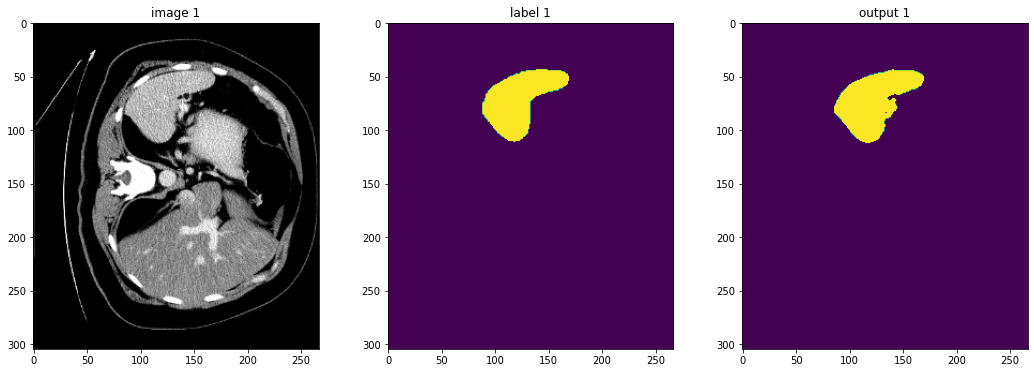

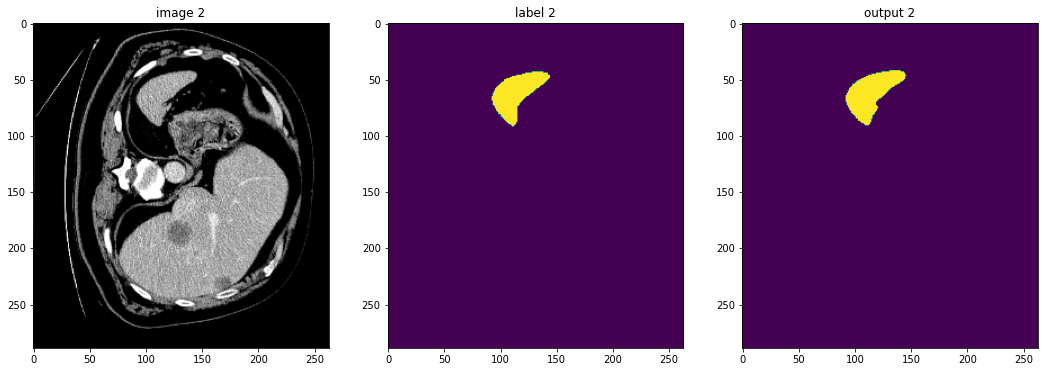

In [ ]:
from monai.apps import download_url

resource = "http://drive.google.com/uc?id=1y4R8zYKl3rnUDhQvPuv4tMskGFmhndtw"
md5 = "8049059a15f248e0f4209ba37ec89119"

model_file = os.path.join(root_dir, "full_train.pth")

if not os.path.exists(model_file):
    download_url(resource, model_file, md5)

model.load_state_dict(torch.load(os.path.join(root_dir, model_file)))
model.eval()
visualize_model(model)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)